<a href="https://colab.research.google.com/github/2303A51751/Python-for-data-science-B-11-/blob/main/IEEE_codes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# burnout_xai_ml_pipeline.py
# IEEE Paper: Explainable AI for Workplace Mental Health Prediction

import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Optional: trending libraries
try:
    import xgboost as xgb
except ImportError:
    xgb = None
try:
    import lightgbm as lgb
except ImportError:
    lgb = None
try:
    from catboost import CatBoostClassifier
except ImportError:
    CatBoostClassifier = None

# Load dataset
file_path = "/content/mental_health_workplace_survey.csv"  # change path if running locally
df = pd.read_csv(file_path)

# Target column
target_col = "BurnoutRisk"
if target_col not in df.columns:
    raise ValueError(f"Target column {target_col} not found in dataset")

# Split features and labels
X = df.drop(columns=[target_col])
y = df[target_col]

# Identify categorical & numeric
categorical_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Pipelines
numeric_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pre, numeric_cols),
    ("cat", categorical_pre, categorical_cols)
], remainder="drop")

def make_pipeline(model):
    return Pipeline([("pre", preprocessor), ("clf", model)])

# Models
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "LinearSVC_Calibrated": CalibratedClassifierCV(LinearSVC(class_weight="balanced"), method="sigmoid", cv=3),
    "SVC_RBF": SVC(kernel="rbf", probability=True, class_weight="balanced"),
    "DecisionTree": DecisionTreeClassifier(class_weight="balanced"),
    "RandomForest": RandomForestClassifier(n_estimators=200, class_weight="balanced_subsample"),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=200, class_weight="balanced"),
    "GradientBoosting": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(n_neighbors=15, weights="distance"),
    "GaussianNB": GaussianNB(),
    "MLP": MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300),
    "LDA": LinearDiscriminantAnalysis()
}

if xgb is not None:
    models["XGBoost"] = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
if lgb is not None:
    models["LightGBM"] = lgb.LGBMClassifier(class_weight="balanced")
if CatBoostClassifier is not None:
    models["CatBoost"] = CatBoostClassifier(verbose=0)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Ensure output directory
os.makedirs("outputs/confusion_matrices", exist_ok=True)

# Evaluate models
results = []
for name, model in models.items():
    print(f"\n=== Training {name} ===")
    try:
        pipe = make_pipeline(model)
        pipe.fit(X_train, y_train)

        # Predictions
        y_pred = pipe.predict(X_test)

        # If probas available
        if hasattr(pipe, "predict_proba"):
            y_proba = pipe.predict_proba(X_test)[:, 1]
        else:
            y_proba = None

        # Metrics
        report = classification_report(y_test, y_pred, output_dict=True)
        acc = report["accuracy"]
        prec = report["weighted avg"]["precision"]
        rec = report["weighted avg"]["recall"]
        f1 = report["weighted avg"]["f1-score"]
        roc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
        pr = average_precision_score(y_test, y_proba) if y_proba is not None else np.nan

        cv_acc = cross_val_score(pipe, X, y, cv=5).mean()

        results.append({
            "model": name,
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1_score": f1,
            "roc_auc": roc,
            "pr_auc": pr,
            "cv_accuracy": cv_acc
        })

        # Save classification report
        with open(f"outputs/{name}_report.txt", "w") as f:
            f.write(classification_report(y_test, y_pred))

        # Save confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        pd.DataFrame(cm).to_csv(f"outputs/confusion_matrices/{name}_cm.csv", index=False)

    except Exception as e:
        print(f"Error training {name}: {e}")
        results.append({"model": name, "error": str(e)})

# Results summary
results_df = pd.DataFrame(results)
results_df.to_csv("outputs/model_reports.csv", index=False)
print("\n=== Final Results ===")
print(results_df.sort_values("f1_score", ascending=False))


=== Training LogisticRegression ===

=== Training LinearSVC_Calibrated ===

=== Training SVC_RBF ===

=== Training DecisionTree ===

=== Training RandomForest ===

=== Training ExtraTrees ===

=== Training GradientBoosting ===

=== Training KNN ===

=== Training GaussianNB ===

=== Training MLP ===

=== Training LDA ===

=== Training XGBoost ===


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:24:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:24:04] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:24:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:24:05] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:24:06] WARNING: /w


=== Training LightGBM ===
[LightGBM] [Info] Number of positive: 735, number of negative: 1515
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2537
[LightGBM] [Info] Number of data points in the train set: 2250, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 784, number of negative: 1616
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2535
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 784, number of negative: 1616
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2538
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 53
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [ ]:
# unsupervised_ml_pipeline.py
"""
Unsupervised analysis pipeline for workplace mental health dataset
- Loads: /mnt/data/mental_health_workplace_survey.csv
- Produces clusters, dimensionality reductions, anomaly detection
- Saves: cluster labels, metrics, cluster profiles, and plots in ./unsupervised_outputs/
"""

import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import pairwise_distances

import matplotlib.pyplot as plt

# Optional: UMAP (if installed)
try:
    import umap
    _UMAP_AVAILABLE = True
except Exception:
    _UMAP_AVAILABLE = False

# Optional: HDBSCAN (if installed)
try:
    import hdbscan
    _HDBSCAN_AVAILABLE = True
except Exception:
    _HDBSCAN_AVAILABLE = False

# -----------------------
# Config
# -----------------------
DATA_PATH = "/content/mental_health_workplace_survey.csv"
OUTPUT_DIR = "./unsupervised_outputs"
RANDOM_STATE = 42
KMEANS_K_RANGE = range(2, 11)  # search K between 2 and 10
TSNE_PERPLEXITY = 30
TSNE_N_COMPONENTS = 2

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "plots"), exist_ok=True)

# -----------------------
# Load dataset
# -----------------------
df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", df.shape)

# Drop identifiers if present
if "EmployeeID" in df.columns:
    df = df.drop(columns=["EmployeeID"])

# We'll keep a copy of original features for profiling later
df_original = df.copy()

# For unsupervised tasks we remove the target column if exists (BurnoutRisk)
if "BurnoutRisk" in df.columns:
    df = df.drop(columns=["BurnoutRisk"])

# -----------------------
# Detect feature types
# -----------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in df.columns if c not in numeric_cols]

print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)

# -----------------------
# Preprocessing pipeline
# -----------------------
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
], remainder="drop")

# Fit-preprocess to get transformed feature matrix
X_pre = preprocessor.fit_transform(df)
print("Preprocessed X shape:", X_pre.shape)

# Get human-readable feature names after one-hot encoding
feature_names = []
if len(numeric_cols) > 0:
    feature_names.extend(numeric_cols)
if len(categorical_cols) > 0:
    # sklearn >=1.0: get_feature_names_out, older: get_feature_names
    try:
        cat_names = preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_cols)
    except Exception:
        cat_names = preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names(categorical_cols)
    feature_names.extend(list(cat_names))

# Save feature names
with open(os.path.join(OUTPUT_DIR, "feature_names.txt"), "w") as f:
    for feat in feature_names:
        f.write(f"{feat}\n")

# -----------------------
# Dimensionality reduction: PCA (retain explained variance) + t-SNE + optional UMAP
# -----------------------
print("Running PCA...")
pca = PCA(n_components=0.95, random_state=RANDOM_STATE)  # preserve 95% variance
X_pca = pca.fit_transform(X_pre)
print("PCA components:", X_pca.shape[1])

# Save PCA explained ratios
pd.DataFrame({
    "component": np.arange(1, len(pca.explained_variance_ratio_)+1),
    "explained_variance_ratio": pca.explained_variance_ratio_
}).to_csv(os.path.join(OUTPUT_DIR, "pca_explained_variance.csv"), index=False)

# 2D PCA for plotting
pca_2 = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca2 = pca_2.fit_transform(X_pre)

plt.figure(figsize=(8,6))
plt.scatter(X_pca2[:,0], X_pca2[:,1], s=8, alpha=0.6)
plt.title("PCA (2 components) - all samples")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "plots", "pca_scatter.png"), dpi=200)
plt.close()

# t-SNE (2D)
print("Running t-SNE (this may take a while)...")
tsne = TSNE(n_components=2, perplexity=TSNE_PERPLEXITY, random_state=RANDOM_STATE, n_jobs=1)
X_tsne = tsne.fit_transform(X_pre)
plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=8, alpha=0.6)
plt.title("t-SNE (2D) - all samples")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "plots", "tsne_scatter.png"), dpi=200)
plt.close()

# optional UMAP
if _UMAP_AVAILABLE:
    print("Running UMAP...")
    reducer = umap.UMAP(n_components=2, random_state=RANDOM_STATE)
    X_umap = reducer.fit_transform(X_pre)
    plt.figure(figsize=(8,6))
    plt.scatter(X_umap[:,0], X_umap[:,1], s=8, alpha=0.6)
    plt.title("UMAP (2D) - all samples")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "plots", "umap_scatter.png"), dpi=200)
    plt.close()
else:
    print("UMAP not available; skipping UMAP.")

# -----------------------
# Clustering: KMeans (search K), Agglomerative, DBSCAN, GMM
# -----------------------
cluster_labels = {}
cluster_metrics = []

# Helper to compute and store metrics
def evaluate_and_store(name, labels, X_vect):
    if len(set(labels)) <= 1:
        sil = np.nan
        db = np.nan
    else:
        sil = silhouette_score(X_vect, labels)
        db = davies_bouldin_score(X_vect, labels)
    cluster_metrics.append({
        "method": name,
        "n_clusters": len(set(labels)) - (1 if -1 in labels else 0),
        "silhouette": sil,
        "davies_bouldin": db
    })
    cluster_labels[name] = labels
    print(f"{name}: clusters={len(set(labels)) - (1 if -1 in labels else 0)}, silhouette={sil:.4f}, db={db:.4f}")

# 1) KMeans with silhouette search
best_k = None
best_sil = -1.0
best_labels = None
print("Searching best K for KMeans (k in {})".format(list(KMEANS_K_RANGE)))
for k in KMEANS_K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(X_pre)
    if len(set(labels)) > 1:
        sil = silhouette_score(X_pre, labels)
    else:
        sil = -1
    print(f"  K={k} -> silhouette={sil:.4f}")
    if sil > best_sil:
        best_sil = sil
        best_k = k
        best_labels = labels

if best_labels is not None:
    evaluate_and_store(f"KMeans_k{best_k}", best_labels, X_pre)

# 2) Agglomerative (try a few settings)
for linkage in ["ward", "average", "complete"]:
    # 'ward' requires Euclidean and numeric features; after onehot it's okay since data is numeric
    try:
        for n in [2, 3, 4, 5, 6]:
            agg = AgglomerativeClustering(n_clusters=n, linkage=linkage)
            labels = agg.fit_predict(X_pre)
            name = f"Agg_{linkage}_k{n}"
            evaluate_and_store(name, labels, X_pre)
    except Exception as e:
        print("Agglomerative error:", e)

# 3) DBSCAN (density-based)
print("Running DBSCAN with a few eps values...")
for eps in [0.5, 1.0, 1.5, 2.0]:
    db = DBSCAN(eps=eps, min_samples=5, metric="euclidean", n_jobs=1)
    labels = db.fit_predict(X_pre)
    evaluate_and_store(f"DBSCAN_eps{eps}", labels, X_pre)

# 4) Gaussian Mixture Model
for k in [2,3,4,5,6]:
    try:
        gmm = GaussianMixture(n_components=k, random_state=RANDOM_STATE, n_init=3)
        labels = gmm.fit_predict(X_pre)
        evaluate_and_store(f"GMM_k{k}", labels, X_pre)
    except Exception as e:
        print("GMM error:", e)

# 5) Optional: HDBSCAN
if _HDBSCAN_AVAILABLE:
    print("Running HDBSCAN...")
    clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
    labels = clusterer.fit_predict(X_pre)
    evaluate_and_store("HDBSCAN", labels, X_pre)
else:
    print("HDBSCAN not available; skipping.")

# Save cluster metrics
pd.DataFrame(cluster_metrics).to_csv(os.path.join(OUTPUT_DIR, "cluster_metrics_summary.csv"), index=False)

# Save labels per method
labels_df = pd.DataFrame({k: v for k, v in cluster_labels.items()})
labels_df.to_csv(os.path.join(OUTPUT_DIR, "cluster_labels_all_methods.csv"), index=False)

# -----------------------
# Cluster profiling: create interpretable profiles per cluster using original features
# -----------------------
def profile_clusters(labels, method_name):
    # Build DataFrame with original features and cluster label
    d = df_original.copy()
    d["_cluster"] = labels
    # For numeric features: compute mean; for categorical: top frequency
    profile = {}
    for cluster in sorted(set(labels)):
        if cluster == -1:
            labname = "noise"
        else:
            labname = f"cluster_{cluster}"
        subset = d[d["_cluster"] == cluster]
        if subset.shape[0] == 0:
            continue
        numeric_summary = subset[numeric_cols].mean().to_dict() if len(numeric_cols)>0 else {}
        cat_summary = {}
        for col in categorical_cols:
            top = subset[col].mode()
            if len(top) > 0:
                cat_summary[col+"_top"] = top.iloc[0]
                # proportion of top category
                cat_summary[col+"_top_prop"] = (subset[col] == top.iloc[0]).mean()
            else:
                cat_summary[col+"_top"] = None
                cat_summary[col+"_top_prop"] = np.nan
        profile[labname] = {"size": subset.shape[0], **numeric_summary, **cat_summary}
    # convert to DataFrame
    prof_df = pd.DataFrame(profile).T
    prof_df.index.name = "cluster"
    prof_df.to_csv(os.path.join(OUTPUT_DIR, f"cluster_profile_{method_name}.csv"))
    return prof_df

# Generate profiles for top clustering methods (choose a subset)
for method in list(cluster_labels.keys()):
    profile_clusters(cluster_labels[method], method)

# -----------------------
# Anomaly detection
# -----------------------
anomaly_results = {}

# Isolation Forest
print("Fitting IsolationForest...")
iso = IsolationForest(n_estimators=200, contamination=0.05, random_state=RANDOM_STATE)
iso_preds = iso.fit_predict(X_pre)  # -1 for outliers, 1 for inliers
iso_labels = np.where(iso_preds == -1, 1, 0)  # 1 = anomaly
anomaly_results["IsolationForest"] = iso_labels
pd.DataFrame({"anomaly_ISO": iso_labels}).to_csv(os.path.join(OUTPUT_DIR, "anomalies_isolationforest.csv"), index=False)

# Local Outlier Factor (unsupervised - negative_outlier_factor)
print("Fitting LocalOutlierFactor...")
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=False)
lof_preds = lof.fit_predict(X_pre)  # -1 for outliers
lof_labels = np.where(lof_preds == -1, 1, 0)
anomaly_results["LOF"] = lof_labels
pd.DataFrame({"anomaly_LOF": lof_labels}).to_csv(os.path.join(OUTPUT_DIR, "anomalies_lof.csv"), index=False)

# OneClassSVM
print("Fitting OneClassSVM...")
ocsvm = OneClassSVM(kernel="rbf", gamma='scale', nu=0.05)
ocsvm.fit(X_pre)
oc_preds = ocsvm.predict(X_pre)
oc_labels = np.where(oc_preds == -1, 1, 0)
anomaly_results["OneClassSVM"] = oc_labels
pd.DataFrame({"anomaly_OCSVM": oc_labels}).to_csv(os.path.join(OUTPUT_DIR, "anomalies_ocsvm.csv"), index=False)

# Save anomaly summary counts
anomaly_summary = {k: int(np.sum(v)) for k, v in anomaly_results.items()}
pd.DataFrame([anomaly_summary]).T.rename(columns={0:"num_anomalies"}).to_csv(os.path.join(OUTPUT_DIR, "anomaly_summary.csv"))

# -----------------------
# Save representative scatter plots per clustering method (t-SNE coordinates colored by cluster)
# -----------------------
tsne_df = pd.DataFrame(X_tsne, columns=["tsne1", "tsne2"])
for method, labels in cluster_labels.items():
    try:
        plt.figure(figsize=(8,6))
        unique_labels = sorted(set(labels))
        palette = plt.cm.get_cmap("tab20", len(unique_labels))
        for idx, lab in enumerate(unique_labels):
            mask = (labels == lab)
            plt.scatter(tsne_df.loc[mask, "tsne1"], tsne_df.loc[mask, "tsne2"], s=8, alpha=0.6, label=str(lab), color=palette(idx))
        plt.title(f"t-SNE colored by {method}")
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize="small", ncol=1)
        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, "plots", f"tsne_{method}.png"), dpi=200)
        plt.close()
    except Exception as e:
        print("Plot error for", method, e)

# -----------------------
# Save everything
# -----------------------
# 1) cluster metrics summary already saved
# 2) labels saved
# 3) cluster profiles saved
# 4) anomaly files saved
# 5) tsne/pca plots saved

print("Unsupervised analysis complete.")
print("Outputs saved to:", OUTPUT_DIR)

Loaded dataset: (3000, 25)
Numeric cols: ['Age', 'YearsAtCompany', 'WorkHoursPerWeek', 'BurnoutLevel', 'JobSatisfaction', 'StressLevel', 'ProductivityScore', 'SleepHours', 'PhysicalActivityHrs', 'CommuteTime', 'ManagerSupportScore', 'MentalHealthDaysOff', 'WorkLifeBalanceScore', 'TeamSize', 'CareerGrowthScore']
Categorical cols: ['Gender', 'Country', 'JobRole', 'Department', 'RemoteWork', 'HasMentalHealthSupport', 'HasTherapyAccess', 'SalaryRange']
Preprocessed X shape: (3000, 52)
Running PCA...
PCA components: 36
Running t-SNE (this may take a while)...
Running UMAP...
Searching best K for KMeans (k in [2, 3, 4, 5, 6, 7, 8, 9, 10])
  K=2 -> silhouette=0.0366
  K=3 -> silhouette=0.0315
  K=4 -> silhouette=0.0317
  K=5 -> silhouette=0.0304
  K=6 -> silhouette=0.0308
  K=7 -> silhouette=0.0309
  K=8 -> silhouette=0.0317
  K=9 -> silhouette=0.0321
  K=10 -> silhouette=0.0315
KMeans_k2: clusters=2, silhouette=0.0366, db=5.0579
Agg_ward_k2: clusters=2, silhouette=0.0133, db=8.5293
Agg_ward_

In [ ]:
"""
deep_learning_burnout.py

Comprehensive deep learning script for BurnoutRisk (0/1) prediction
using the dataset: /mnt/data/mental_health_workplace_survey.csv

Models included:
- Keras MLP (dense feedforward)
- Keras Wide & Deep (wide: linear over OHE features; deep: dense on numeric)
- Autoencoder (for anomaly detection / representation learning)

Outputs:
- ./dl_outputs/<model_name>/ model files and training history
- ./dl_outputs/reports.csv overall metrics per model
- ./dl_outputs/<model_name>_classification_report.txt per-model text reports
- optional: SHAP explanations (if shap installed)

Requirements:
pip install numpy pandas scikit-learn tensorflow shap matplotlib
(If using GPU, install tensorflow-gpu as appropriate)
"""

import os
import random
import json
import numpy as np
import pandas as pd
from collections import defaultdict

# reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# ML / DL libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Keras
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers, models, callbacks, regularizers
except Exception as e:
    raise ImportError("TensorFlow/Keras required. Install via `pip install tensorflow`. Error: " + str(e))

# optional explainability
SHAP_AVAILABLE = True
try:
    import shap
except Exception:
    SHAP_AVAILABLE = False

# ---------------------------
# Config
# ---------------------------
DATA_PATH = "/content/mental_health_workplace_survey.csv"
TARGET = "BurnoutRisk"
OUTPUT_DIR = "./dl_outputs"
TEST_SIZE = 0.2
VAL_SIZE = 0.2  # fraction of train used for validation
BATCH_SIZE = 64
EPOCHS = 80
PATIENCE = 8

os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---------------------------
# Load dataset
# ---------------------------
df = pd.read_csv(DATA_PATH)
if TARGET not in df.columns:
    raise ValueError(f"{TARGET} not found in dataset")

# Drop ID columns if present
if "EmployeeID" in df.columns:
    df = df.drop(columns=["EmployeeID"])

# Define numeric and categorical features automatically
numeric_cols = df.select_dtypes(include=["number"]).columns.tolist()
if TARGET in numeric_cols:
    numeric_cols.remove(TARGET)
categorical_cols = [c for c in df.columns if c not in numeric_cols + [TARGET]]

# If RemoteWork coded as 'Yes'/'No', include it in categorical
# show a quick peek
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)
print("Rows:", len(df))

# ---------------------------
# Preprocessing
# ---------------------------
# Pipelines: numeric -> median impute + std scale. categorical -> mode impute + OneHot
numeric_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pipeline, numeric_cols),
    ("cat", categorical_pipeline, categorical_cols)
], remainder="drop")

# Fit preprocessor to entire dataset (so feature dims are known)
X_all = df.drop(columns=[TARGET])
y_all = df[TARGET].astype(int)
preprocessor.fit(X_all)  # to get output dims

# Extract feature names after preprocessing
# numeric feature names (kept)
num_names = numeric_cols
# categorical feature names from encoder
try:
    cat_encoder = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_names = cat_encoder.get_feature_names_out(categorical_cols).tolist()
except Exception:
    # older sklearn
    cat_encoder = preprocessor.named_transformers_["cat"].named_steps["onehot"]
    cat_names = cat_encoder.get_feature_names(categorical_cols).tolist()

feature_names = num_names + cat_names
INPUT_DIM = len(feature_names)
print("Total input dim after preprocessing:", INPUT_DIM)

# Full transformation function
def transform_df(X_df):
    X_trans = preprocessor.transform(X_df)
    # ensure float32 for TF
    return X_trans.astype("float32")

# ---------------------------
# Train/test split
# ---------------------------
X = X_all
y = y_all.values
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, stratify=y, random_state=SEED
)
# further split train-> train + val
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=VAL_SIZE, stratify=y_trainval, random_state=SEED
)

# Transform numeric + categorical to arrays
X_train_t = transform_df(X_train)
X_val_t = transform_df(X_val)
X_test_t = transform_df(X_test)

print("Train shape:", X_train_t.shape, "Val shape:", X_val_t.shape, "Test shape:", X_test_t.shape)

# ---------------------------
# Utility: metrics & save helper
# ---------------------------
def evaluate_and_save(model, X_test, y_test, out_dir, model_name):
    preds_proba = model.predict(X_test).ravel()
    try:
        preds = (preds_proba >= 0.5).astype(int)
    except Exception:
        preds = model.predict(X_test)
        # if predicted classes, ensure int
        preds = np.array(preds).astype(int)
        preds_proba = preds  # fallback

    acc = accuracy_score(y_test, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, preds, average="binary", zero_division=0)
    try:
        roc = roc_auc_score(y_test, preds_proba)
    except Exception:
        roc = np.nan
    try:
        pr = average_precision_score(y_test, preds_proba)
    except Exception:
        pr = np.nan

    report_txt = classification_report(y_test, preds, zero_division=0)
    with open(os.path.join(out_dir, f"{model_name}_classification_report.txt"), "w") as f:
        f.write(report_txt)
    # confusion matrix
    cm = confusion_matrix(y_test, preds)
    pd.DataFrame(cm, index=["Actual_0", "Actual_1"], columns=["Pred_0", "Pred_1"]).to_csv(os.path.join(out_dir, f"{model_name}_confusion_matrix.csv"))

    metrics = {
        "model": model_name,
        "accuracy": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "roc_auc": float(roc) if not np.isnan(roc) else None,
        "pr_auc": float(pr) if not np.isnan(pr) else None
    }
    with open(os.path.join(out_dir, f"{model_name}_metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)
    print(f"[{model_name}] acc={acc:.4f} prec={prec:.4f} rec={rec:.4f} f1={f1:.4f} roc={roc:.4f} pr={pr:.4f}")
    return metrics, preds, preds_proba

# compute class weights for imbalance
class_weights = compute_class_weight("balanced", classes=np.unique(y_train), y=y_train)
cw_dict = {i: w for i, w in enumerate(class_weights)}
print("Class weights (train):", cw_dict)

# ---------------------------
# Model 1: MLP (Keras Sequential)
# ---------------------------
def build_mlp(input_dim, dropout=0.3, l2=1e-4):
    inputs = keras.Input(shape=(input_dim,), name="inputs")
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(l2))(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(dropout*0.5)(x)
    out = layers.Dense(1, activation="sigmoid", name="out")(x)
    model = keras.Model(inputs=inputs, outputs=out, name="MLP")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="binary_crossentropy", metrics=["AUC"])
    return model

mlp_model = build_mlp(INPUT_DIM)
mlp_dir = os.path.join(OUTPUT_DIR, "MLP")
os.makedirs(mlp_dir, exist_ok=True)

es = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", patience=4, factor=0.5, min_lr=1e-6)

history_mlp = mlp_model.fit(
    X_train_t, y_train,
    validation_data=(X_val_t, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE,
    class_weight=cw_dict,
    callbacks=[es, reduce_lr],
    verbose=2
)
mlp_model.save(os.path.join(mlp_dir, "model.h5"))
pd.DataFrame(history_mlp.history).to_csv(os.path.join(mlp_dir, "history.csv"), index=False)
metrics_mlp, preds_mlp, probs_mlp = evaluate_and_save(mlp_model, X_test_t, y_test, mlp_dir, "MLP")

# Optional: SHAP for MLP
if SHAP_AVAILABLE:
    try:
        explainer = shap.KernelExplainer(mlp_model.predict, shap.kmeans(X_train_t, 50))
        # compute shap values for a sample of test set to keep compute reasonable
        sample = X_test_t[np.random.choice(len(X_test_t), size=min(200, len(X_test_t)), replace=False)]
        shap_vals = explainer.shap_values(sample, nsamples=200)
        # save shap summary (mean abs)
        mean_abs = np.mean(np.abs(shap_vals), axis=0)
        shap_df = pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs})
        shap_df = shap_df.sort_values("mean_abs_shap", ascending=False)
        shap_df.to_csv(os.path.join(mlp_dir, "shap_global_mlp.csv"), index=False)
        print("Saved SHAP global importances for MLP")
    except Exception as e:
        print("SHAP for MLP failed:", e)
else:
    print("SHAP not available. To enable: pip install shap")

# ---------------------------
# Model 2: Wide & Deep (Keras Functional)
# wide: linear on OHE-cat features (we use full preprocessed features as both wide and deep for simplicity)
# deep: dense layers
# For more sophisticated wide/deep separate embeddings can be built for categorical features.
# ---------------------------
def build_wide_and_deep(input_dim, wide_dim=None):
    inputs = keras.Input(shape=(input_dim,), name="inputs")
    # wide path (linear)
    wide_out = layers.Dense(1, activation=None, name="wide_linear")(inputs)  # single logit
    # deep path
    x = layers.Dense(256, activation="relu")(inputs)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    deep_out = layers.Dense(1, activation=None)(x)  # logit
    # combine logits
    combined = layers.Add()([wide_out, deep_out])
    output = layers.Activation("sigmoid")(combined)
    model = keras.Model(inputs=inputs, outputs=output, name="WideDeep")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=5e-4), loss="binary_crossentropy", metrics=["AUC"])
    return model

wd_model = build_wide_and_deep(INPUT_DIM)
wd_dir = os.path.join(OUTPUT_DIR, "WideDeep")
os.makedirs(wd_dir, exist_ok=True)

es_wd = callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)
history_wd = wd_model.fit(
    X_train_t, y_train,
    validation_data=(X_val_t, y_val),
    epochs=EPOCHS, batch_size=BATCH_SIZE, class_weight=cw_dict,
    callbacks=[es_wd, reduce_lr], verbose=2
)
wd_model.save(os.path.join(wd_dir, "model.h5"))
pd.DataFrame(history_wd.history).to_csv(os.path.join(wd_dir, "history.csv"), index=False)
metrics_wd, preds_wd, probs_wd = evaluate_and_save(wd_model, X_test_t, y_test, wd_dir, "WideDeep")

# SHAP for WideDeep (if available)
if SHAP_AVAILABLE:
    try:
        explainer = shap.KernelExplainer(wd_model.predict, shap.kmeans(X_train_t, 50))
        sample = X_test_t[np.random.choice(len(X_test_t), size=min(200, len(X_test_t)), replace=False)]
        shap_vals = explainer.shap_values(sample, nsamples=200)
        mean_abs = np.mean(np.abs(shap_vals), axis=0)
        shap_df = pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs})
        shap_df = shap_df.sort_values("mean_abs_shap", ascending=False)
        shap_df.to_csv(os.path.join(wd_dir, "shap_global_widedeep.csv"), index=False)
        print("Saved SHAP global importances for WideDeep")
    except Exception as e:
        print("SHAP for WideDeep failed:", e)

# ---------------------------
# Model 3: Autoencoder (unsupervised). Use for anomaly detection or feature pretraining.
# Train autoencoder on training set (could be on 'low-risk' group only). Then use reconstruction error.
# ---------------------------
ae_dir = os.path.join(OUTPUT_DIR, "Autoencoder")
os.makedirs(ae_dir, exist_ok=True)

def build_autoencoder(input_dim, latent_dim=32):
    inp = keras.Input(shape=(input_dim,))
    x = layers.Dense(256, activation="relu")(inp)
    x = layers.Dense(128, activation="relu")(x)
    z = layers.Dense(latent_dim, activation="relu", name="latent")(x)
    x = layers.Dense(128, activation="relu")(z)
    x = layers.Dense(256, activation="relu")(x)
    out = layers.Dense(input_dim, activation="linear")(x)
    ae = keras.Model(inputs=inp, outputs=out, name="Autoencoder")
    ae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss="mse")
    return ae

# Option: train autoencoder on non-burnout samples only to model "healthy" patterns
train_mask_nonburn = (y_train == 0)
if np.sum(train_mask_nonburn) < max(20, 0.1 * len(y_train)):
    # fallback: train on whole train set if not enough non-burnout instances
    X_ae_train = X_train_t
else:
    X_ae_train = X_train_t[train_mask_nonburn]

ae = build_autoencoder(INPUT_DIM, latent_dim=32)
es_ae = callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
history_ae = ae.fit(
    X_ae_train, X_ae_train,
    validation_split=0.1,
    epochs=100, batch_size=128,
    callbacks=[es_ae],
    verbose=2
)
ae.save(os.path.join(ae_dir, "autoencoder.h5"))
pd.DataFrame(history_ae.history).to_csv(os.path.join(ae_dir, "history.csv"), index=False)

# Compute reconstruction error on test set and produce AUC vs true BurnoutRisk (higher recon error may correlate with burnout)
recon_test = ae.predict(X_test_t)
recon_err = np.mean(np.square(recon_test - X_test_t), axis=1)
# Save recon errors
pd.DataFrame({"recon_err": recon_err, "true": y_test}).to_csv(os.path.join(ae_dir, "recon_errors_test.csv"), index=False)
try:
    recon_auc = roc_auc_score(y_test, recon_err)
except Exception:
    recon_auc = None
print("Autoencoder reconstruction error AUC (vs Burnout label):", recon_auc)

# ---------------------------
# Summary of results -> aggregate metrics
# ---------------------------
metrics_list = []
for d in [mlp_dir, wd_dir]:
    mfile = os.path.join(d, os.path.basename(d) + "_metrics.json")
    # our metrics saved as <model>_metrics.json
    # find any metrics json in directory
    js = None
    for f in os.listdir(d):
        if f.endswith("_metrics.json"):
            js = os.path.join(d, f)
            break
    if js:
        with open(js, "r") as f:
            metrics_list.append(json.load(f))
# include autoencoder recon auc
metrics_list.append({"model": "Autoencoder", "roc_auc_recon_err": recon_auc})

pd.DataFrame(metrics_list).to_csv(os.path.join(OUTPUT_DIR, "dl_summary_metrics.csv"), index=False)
print("Saved summary metrics to:", os.path.join(OUTPUT_DIR, "dl_summary_metrics.csv"))

# ---------------------------
# Guidance / Next steps to improve results & XAI
# ---------------------------
print("""
Done training deep models.

Next recommended steps for your IEEE paper:
- Report test set metrics (accuracy, precision, recall, f1, ROC-AUC, PR-AUC) from saved json files.
- Use SHAP (DeepExplainer or KernelExplainer) to produce local explanations for key test samples and a global feature importance table.
- Compare with classical baselines (RandomForest, XGBoost) and show calibration plots (reliability curves).
- For tabular deep learning research, consider TabNet or TabTransformer (pytorch-tabnet or tensorflow-addons implementations) and compare.
- Include ablation: numeric-only, categorical-only, and with/without support features (HasTherapyAccess, ManagerSupportScore).
""")

Numeric cols: ['Age', 'YearsAtCompany', 'WorkHoursPerWeek', 'BurnoutLevel', 'JobSatisfaction', 'StressLevel', 'ProductivityScore', 'SleepHours', 'PhysicalActivityHrs', 'CommuteTime', 'ManagerSupportScore', 'MentalHealthDaysOff', 'WorkLifeBalanceScore', 'TeamSize', 'CareerGrowthScore']
Categorical cols: ['Gender', 'Country', 'JobRole', 'Department', 'RemoteWork', 'HasMentalHealthSupport', 'HasTherapyAccess', 'SalaryRange']
Rows: 3000
Total input dim after preprocessing: 52
Train shape: (1920, 52) Val shape: (480, 52) Test shape: (600, 52)
Class weights (train): {0: np.float64(0.7424593967517401), 1: np.float64(1.5311004784688995)}
Epoch 1/80
30/30 - 4s - 121ms/step - AUC: 0.7932 - loss: 0.5930 - val_AUC: 0.9660 - val_loss: 0.5072 - learning_rate: 1.0000e-03
Epoch 2/80
30/30 - 0s - 6ms/step - AUC: 0.9652 - loss: 0.2757 - val_AUC: 0.9815 - val_loss: 0.3715 - learning_rate: 1.0000e-03
Epoch 3/80
30/30 - 0s - 7ms/step - AUC: 0.9819 - loss: 0.2023 - val_AUC: 0.9871 - val_loss: 0.2863 - learn

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[MLP] acc=0.9583 prec=0.9296 rec=0.9439 f1=0.9367 roc=0.9929 pr=0.9863
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
[WideDeep] acc=0.9750 prec=0.9594 rec=0.9643 f1=0.9618 roc=0.9967 pr=0.9936
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


  0%|          | 0/200 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
313/313 ━━━━━━

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Autoencoder reconstruction error AUC (vs Burnout label): 0.6276646797332794
Saved summary metrics to: ./dl_outputs/dl_summary_metrics.csv

Done training deep models.

Next recommended steps for your IEEE paper:
- Report test set metrics (accuracy, precision, recall, f1, ROC-AUC, PR-AUC) from saved json files.
- Use SHAP (DeepExplainer or KernelExplainer) to produce local explanations for key test samples and a global feature importance table.
- Compare with classical baselines (RandomForest, XGBoost) and show calibration plots (reliability curves).
- For tabular deep learning research, consider TabNet or TabTransformer (pytorch-tabnet or tensorflow-addons implementations) and compare.
- Include ablation: numeric-only, categorical-only, and with/without support features (HasTherapyAccess, ManagerSupportScore).



In [ ]:
# =========================
# Ensemble Learning for Workplace Mental Health Prediction
# =========================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score

# Base ML models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    BaggingClassifier,
    StackingClassifier,
    VotingClassifier
)
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# =========================
# Load Dataset
# =========================
df = pd.read_csv("/content/mental_health_workplace_survey.csv")

# Assume target column is "burnout_risk"
target = "BurnoutRisk"
X = df.drop(columns=[target])
y = df[target]

# Identify numeric and categorical features
numeric_cols = X.select_dtypes(include=np.number).columns
categorical_cols = X.select_dtypes(exclude=np.number).columns

# Preprocessing
numeric_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pre, numeric_cols),
    ("cat", categorical_pre, categorical_cols)
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# Base Models
# =========================
log_reg = LogisticRegression(max_iter=500, random_state=42)
rf = RandomForestClassifier(n_estimators=200, random_state=42)
gb = GradientBoostingClassifier(n_estimators=200, random_state=42)
xgb = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
lgb = LGBMClassifier(random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42)

# =========================
# 1. Voting Classifier (Hard & Soft Voting)
# =========================
voting_hard = Pipeline([
    ("pre", preprocessor),
    ("clf", VotingClassifier(
        estimators=[("rf", rf), ("gb", gb), ("xgb", xgb)], voting="hard"))
])

voting_soft = Pipeline([
    ("pre", preprocessor),
    ("clf", VotingClassifier(
        estimators=[("rf", rf), ("gb", gb), ("xgb", xgb)], voting="soft"))
])

# =========================
# 2. Bagging (with Decision Tree / Logistic Regression)
# =========================
bagging = Pipeline([
    ("pre", preprocessor),
    ("clf", BaggingClassifier(estimator=rf, n_estimators=50, random_state=42))
])

# =========================
# 3. Boosting (AdaBoost, GradientBoosting, XGBoost, LightGBM, CatBoost)
# =========================
boosting_models = {
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": gb,
    "XGBoost": xgb,
    "LightGBM": lgb,
    "CatBoost": cat
}

# =========================
# 4. Stacking Ensemble
# =========================
stacking = Pipeline([
    ("pre", preprocessor),
    ("clf", StackingClassifier(
        estimators=[("rf", rf), ("gb", gb), ("xgb", xgb), ("lgb", lgb)],
        final_estimator=LogisticRegression(max_iter=500),
        cv=5
    ))
])

# =========================
# Training & Evaluation Function
# =========================
def evaluate_model(name, pipeline):
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    return acc

# =========================
# Run All Ensembles
# =========================
results = {}

# Voting
results["Voting_Hard"] = evaluate_model("Voting_Hard", voting_hard)
results["Voting_Soft"] = evaluate_model("Voting_Soft", voting_soft)

# Bagging
results["Bagging"] = evaluate_model("Bagging_RF", bagging)

# Boosting
for name, model in boosting_models.items():
    pipe = Pipeline([("pre", preprocessor), ("clf", model)])
    results[name] = evaluate_model(name, pipe)

# Stacking
results["Stacking"] = evaluate_model("Stacking", stacking)

# =========================
# Summary
# =========================
print("\n=== Final Ensemble Results ===")
for k, v in results.items():
    print(f"{k}: {v:.4f}")


=== Voting_Hard ===
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       404
           1       1.00      1.00      1.00       196

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


=== Voting_Soft ===
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       404
           1       1.00      1.00      1.00       196

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


=== Bagging_RF ===
Accuracy: 1.0000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       404
           1       1.00      1.00      1.00       196

    accuracy                           1.00       600
   macro avg   

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.4 MB/s eta 0:00:00


In [ ]:
# best_model_ensemble_optimization.py
"""
Optimize ensemble performance for BurnoutRisk prediction.

Requirements (recommended):
- pip install numpy pandas scikit-learn imbalanced-learn xgboost lightgbm shap joblib

Notes:
- XGBoost / LightGBM usage is optional; script falls back gracefully if not installed.
- For large hyperparameter searches, consider reducing n_iter or using GPU-enabled builds.
"""

import os
import json
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score, classification_report, confusion_matrix
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import compute_class_weight
from joblib import dump, load

# Optional libs
try:
    import xgboost as xgb
except Exception:
    xgb = None
try:
    import lightgbm as lgb
except Exception:
    lgb = None
try:
    from imblearn.over_sampling import SMOTE
except Exception:
    SMOTE = None
try:
    import shap
except Exception:
    shap = None

RANDOM_STATE = 42
DATA_PATH = "/content/mental_health_workplace_survey.csv"
TARGET = "BurnoutRisk"
OUTPUT_DIR = "./best_ensemble_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------
# Load dataset
# -------------------------
df = pd.read_csv("/content/mental_health_workplace_survey.csv")
if TARGET not in df.columns:
    raise ValueError(f"Target column '{TARGET}' not found.")

# drop identifiers (if any)
if "EmployeeID" in df.columns:
    df = df.drop(columns=["EmployeeID"])

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# -------------------------
# Feature types
# -------------------------
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

# Make sure binary-like categorical (Yes/No) are treated as categorical
# (Already included above since dtype object)

print(f"Numeric cols: {len(numeric_cols)}, Categorical cols: {len(categorical_cols)}")

# -------------------------
# Preprocessing pipelines
# -------------------------
numeric_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pre = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", numeric_pre, numeric_cols),
    ("cat", categorical_pre, categorical_cols)
], remainder="drop")

# -------------------------
# Train / Test split (stratified)
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Quick imbalance check -> enable SMOTE if imbalance ratio > 1.2
counts = np.bincount(y_train)
imbalance_ratio = (counts.max() / (counts.min() + 1e-9))
use_smote = False
if SMOTE is not None and imbalance_ratio > 1.2:
    use_smote = True
    print("Enabling SMOTE due to imbalance ratio:", imbalance_ratio)
else:
    print("Not using SMOTE. Imbalance ratio:", imbalance_ratio)

# -------------------------
# Feature selection wrapper (SelectFromModel using RandomForest)
# -------------------------
# Build a pipeline up to preprocessing to fit feature selector on training data
X_train_pre = preprocessor.fit_transform(X_train)
# build a small RandomForest to compute importances
selector_rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
selector_rf.fit(X_train_pre, y_train)
sfm = SelectFromModel(selector_rf, threshold="median", prefit=True)

# Get selected feature indices & names
try:
    # get feature names after preprocessing
    num_feats = numeric_cols
    cat_feats = preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names_out(categorical_cols).tolist()
except Exception:
    # fallback names
    try:
        cat_feats = preprocessor.named_transformers_["cat"].named_steps["onehot"].get_feature_names(categorical_cols).tolist()
    except Exception:
        cat_feats = categorical_cols
feature_names = num_feats + cat_feats

selected_mask = sfm.get_support()
selected_features = [feature_names[i] for i, v in enumerate(selected_mask) if v]
print("Selected features count:", len(selected_features))

# We'll build final pipeline that applies preprocessor, then selectFromModel, then classifier.

# -------------------------
# Define base learners (with sensible defaults)
# -------------------------
# Use tuned versions via RandomizedSearchCV below where possible.
estimators_for_stacking = []

# 1) XGBoost (if available)
if xgb is not None:
    xgb_clf = xgb.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric="logloss", n_jobs=-1)
    xgb_param_dist = {
        "n_estimators": [100, 300, 600],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "reg_lambda": [1e-3, 1.0, 10.0]
    }
    xgb_search = RandomizedSearchCV(
        estimator=xgb_clf, param_distributions=xgb_param_dist, n_iter=20, scoring="f1",
        cv=3, random_state=RANDOM_STATE, n_jobs=-1, verbose=1
    )
    print("Tuning XGBoost (this may take time)...")
    xgb_search.fit(sfm.transform(X_train_pre), y_train)
    best_xgb = xgb_search.best_estimator_
    print("XGBoost best params:", xgb_search.best_params_)
    estimators_for_stacking.append(("xgb", best_xgb))
    dump(xgb_search, os.path.join(OUTPUT_DIR, "xgb_search.joblib"))
else:
    print("XGBoost not installed; using RandomForest as a strong tree baseline.")
    best_xgb = None

# 2) LightGBM (if available)
if lgb is not None:
    lgb_clf = lgb.LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    lgb_param = {
        "n_estimators": [200, 400, 800],
        "num_leaves": [31, 63, 127],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.6, 0.8, 1.0]
    }
    lgb_search = RandomizedSearchCV(
        estimator=lgb_clf, param_distributions=lgb_param, n_iter=20, scoring="f1",
        cv=3, random_state=RANDOM_STATE, n_jobs=-1, verbose=1
    )
    print("Tuning LightGBM (this may take time)...")
    lgb_search.fit(sfm.transform(X_train_pre), y_train)
    best_lgb = lgb_search.best_estimator_
    print("LightGBM best params:", lgb_search.best_params_)
    estimators_for_stacking.append(("lgb", best_lgb))
    dump(lgb_search, os.path.join(OUTPUT_DIR, "lgb_search.joblib"))
else:
    best_lgb = None
    print("LightGBM not installed or unavailable.")

# 3) RandomForest baseline (tuned)
rf_clf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_param = {
    "n_estimators": [200, 400],
    "max_depth": [None, 8, 16],
    "max_features": ["sqrt", 0.3, 0.5]
}
rf_search = RandomizedSearchCV(rf_clf, rf_param, n_iter=8, scoring="f1", cv=3, random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
print("Tuning RandomForest...")
rf_search.fit(sfm.transform(X_train_pre), y_train)
best_rf = rf_search.best_estimator_
print("RandomForest best params:", rf_search.best_params_)
estimators_for_stacking.append(("rf", best_rf))
dump(rf_search, os.path.join(OUTPUT_DIR, "rf_search.joblib"))

# Fallback: if no tree-based boosters were tuned, include a LogisticRegression as well
log_clf = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE)
estimators_for_stacking.append(("lr_base", log_clf))

# -------------------------
# Prepare final pipeline: preprocessor -> selected features -> optional SMOTE -> stacking -> calibration
# -------------------------
# We'll construct a wrapper function to fit the whole pipeline
def build_and_train_final_pipeline(X_tr, y_tr, apply_smote=use_smote):
    """
    Returns trained calibrated stacking pipeline and cv scores.
    """
    # Preprocess
    X_tr_pre = preprocessor.transform(X_tr)  # fit already done earlier
    # Feature selection
    X_tr_sel = sfm.transform(X_tr_pre)

    # SMOTE (if desired)
    if apply_smote and SMOTE is not None:
        sm = SMOTE(random_state=RANDOM_STATE)
        X_bal, y_bal = sm.fit_resample(X_tr_sel, y_tr)
        print("After SMOTE shape:", X_bal.shape, np.bincount(y_bal))
    else:
        X_bal, y_bal = X_tr_sel, y_tr.values

    # Build stacking classifier on selected features
    # final_estimator logistic (with penalty)
    final_est = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RANDOM_STATE)
    stacking = StackingClassifier(estimators=estimators_for_stacking, final_estimator=final_est, cv=5, n_jobs=-1, passthrough=False)

    # Fit stacking on balanced data
    stacking.fit(X_bal, y_bal)

    # Calibrate stacking (Platt scaling) using a small CV
    calib = CalibratedClassifierCV(estimator=stacking, method="sigmoid", cv=3)
    calib.fit(X_bal, y_bal)

    return calib

print("Training final stacking + calibration pipeline (this may take some minutes)...")
final_model = build_and_train_final_pipeline(X_train, y_train, apply_smote=use_smote)
dump(final_model, os.path.join(OUTPUT_DIR, "final_stacked_calibrated.joblib"))

# -------------------------
# Evaluate final model on test set
# -------------------------
# Preprocess & select features for test set
X_test_pre = preprocessor.transform(X_test)
X_test_sel = sfm.transform(X_test_pre)

y_pred = final_model.predict(X_test_sel)
try:
    y_proba = final_model.predict_proba(X_test_sel)[:, 1]
except Exception:
    y_proba = final_model.decision_function(X_test_sel)
    # scale to (0,1)
    y_proba = (y_proba - y_proba.min())/(y_proba.max() - y_proba.min() + 1e-9)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary", zero_division=0)
roc = roc_auc_score(y_test, y_proba)
pr = average_precision_score(y_test, y_proba)

metrics = {
    "accuracy": float(acc),
    "precision": float(prec),
    "recall": float(rec),
    "f1": float(f1),
    "roc_auc": float(roc),
    "pr_auc": float(pr)
}
print("Final model test metrics:", metrics)

# Save metrics & classification report & confusion matrix
with open(os.path.join(OUTPUT_DIR, "final_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

with open(os.path.join(OUTPUT_DIR, "final_classification_report.txt"), "w") as f:
    f.write(classification_report(y_test, y_pred, zero_division=0))

pd.DataFrame(confusion_matrix(y_test, y_pred), index=["actual_0","actual_1"], columns=["pred_0","pred_1"]).to_csv(os.path.join(OUTPUT_DIR, "final_confusion_matrix.csv"))

# Save selected features list
with open(os.path.join(OUTPUT_DIR, "selected_features.txt"), "w") as f:
    for feat in selected_features:
        f.write(feat + "\n")

# Save preprocessor and selector for future inference
dump(preprocessor, os.path.join(OUTPUT_DIR, "preprocessor.joblib"))
dump(sfm, os.path.join(OUTPUT_DIR, "feature_selector.joblib"))

# -------------------------
# Feature importance & SHAP (optional, if shap and at least one tree model installed)
# -------------------------
# Prefer to compute SHAP on the single best tree-based model (e.g., XGBoost or LightGBM if available, else RandomForest)
best_tree = None
if best_xgb is not None:
    best_tree = best_xgb
elif best_lgb is not None:
    best_tree = best_lgb
else:
    best_tree = best_rf

# Fit the best_tree on full train set (selected features) for SHAP explanation
if shap is not None and best_tree is not None:
    print("Computing SHAP values for the best tree model (may take time)...")
    # fit on selected training set (if not already fitted during search)
    try:
        best_tree.fit(sfm.transform(preprocessor.transform(X_train)), y_train)
    except Exception:
        pass
    # sample background for SHAP
    sample_idx = np.random.choice(len(X_train), size=min(200, len(X_train)), replace=False)
    background = sfm.transform(preprocessor.transform(X_train.iloc[sample_idx])).astype(float)
    test_sample = sfm.transform(preprocessor.transform(X_test)).astype(float)
    try:
        if xgb is not None and isinstance(best_tree, xgb.XGBClassifier):
            explainer = shap.TreeExplainer(best_tree)
            shap_vals = explainer.shap_values(test_sample)
        else:
            explainer = shap.Explainer(best_tree.predict_proba, background)
            shap_vals = explainer(test_sample)
        # compute mean absolute importance across features
        mean_abs = np.mean(np.abs(shap_vals.values if hasattr(shap_vals, "values") else shap_vals), axis=0)
        imp_df = pd.DataFrame({"feature": selected_features, "mean_abs_shap": mean_abs})
        imp_df = imp_df.sort_values("mean_abs_shap", ascending=False)
        imp_df.to_csv(os.path.join(OUTPUT_DIR, "shap_feature_importance.csv"), index=False)
        print("Saved shap_feature_importance.csv")
    except Exception as e:
        print("SHAP computation failed:", e)
else:
    print("SHAP or suitable tree model not available; skipping SHAP step.")

# -------------------------
# Cross-validated performance estimate of final pipeline (stacking) using StratifiedKFold
# -------------------------
print("Running stratified CV for final_stack on training data to estimate generalization...")
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = []
for train_idx, val_idx in skf.split(X_train, y_train):
    Xt = X_train.iloc[train_idx]; yt = y_train.iloc[train_idx]
    Xv = X_train.iloc[val_idx]; yv = y_train.iloc[val_idx]
    # build a fresh copy of pipeline components (preprocessor & selector are already fitted on full train; we reuse them)
    # transform
    Xt_sel = sfm.transform(preprocessor.transform(Xt))
    Xv_sel = sfm.transform(preprocessor.transform(Xv))
    if use_smote and SMOTE is not None:
        sm = SMOTE(random_state=RANDOM_STATE)
        Xt_sel_bal, yt_bal = sm.fit_resample(Xt_sel, yt)
    else:
        Xt_sel_bal, yt_bal = Xt_sel, yt.values
    # fit stacking (use best estimators we previously tuned)
    stacking_cv = StackingClassifier(estimators=estimators_for_stacking, final_estimator=LogisticRegression(max_iter=2000, class_weight="balanced"), cv=5, n_jobs=-1)
    stacking_cv.fit(Xt_sel_bal, yt_bal)
    yv_proba = stacking_cv.predict_proba(Xv_sel)[:, 1]
    cv_scores.append(roc_auc_score(yv, yv_proba))
print("CV ROC-AUC on train splits:", np.mean(cv_scores), np.std(cv_scores))
with open(os.path.join(OUTPUT_DIR, "cv_train_roc_auc.json"), "w") as f:
    json.dump({"mean": float(np.mean(cv_scores)), "std": float(np.std(cv_scores)), "folds": [float(x) for x in cv_scores]}, f, indent=2)

print("All done. Outputs saved to:", OUTPUT_DIR)
print("Final test metrics:", metrics)

Numeric cols: 15, Categorical cols: 8
Enabling SMOTE due to imbalance ratio: 2.061224489793289
Selected features count: 26
Tuning XGBoost (this may take time)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
XGBoost best params: {'subsample': 0.6, 'reg_lambda': 0.001, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.01, 'colsample_bytree': 0.6}
Tuning LightGBM (this may take time)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 784, number of negative: 1616
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2233
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.326667 -> initscore=-0.723300
[LightGBM] [Info] Start traini

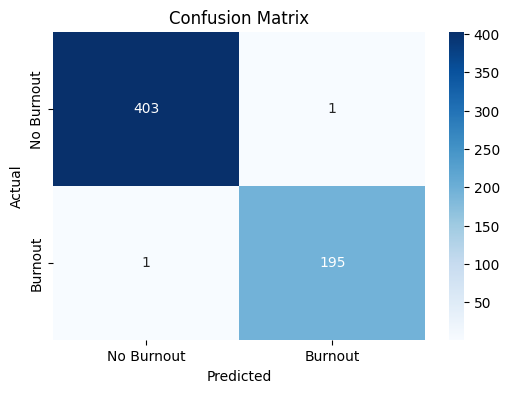

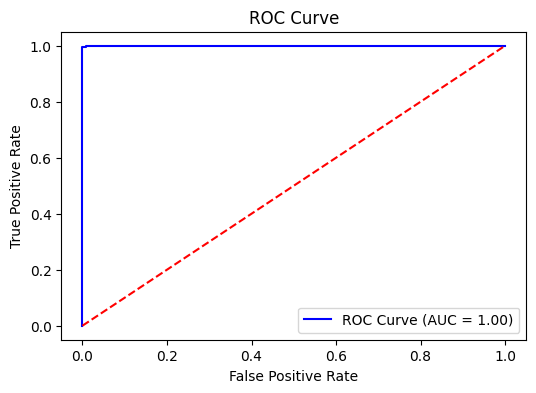

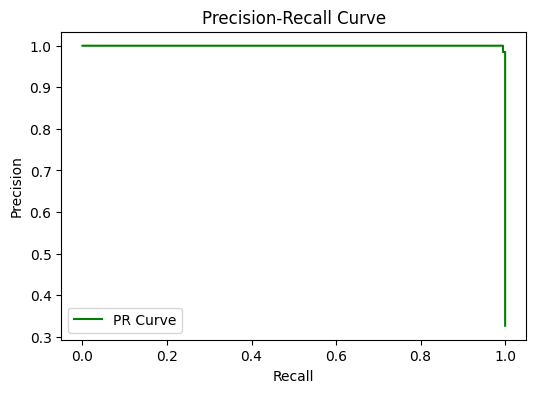

<Figure size 800x600 with 0 Axes>

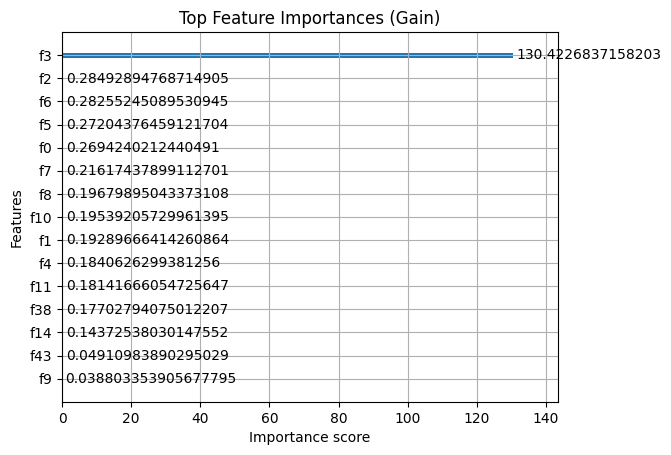


Generating SHAP Summary Plot...


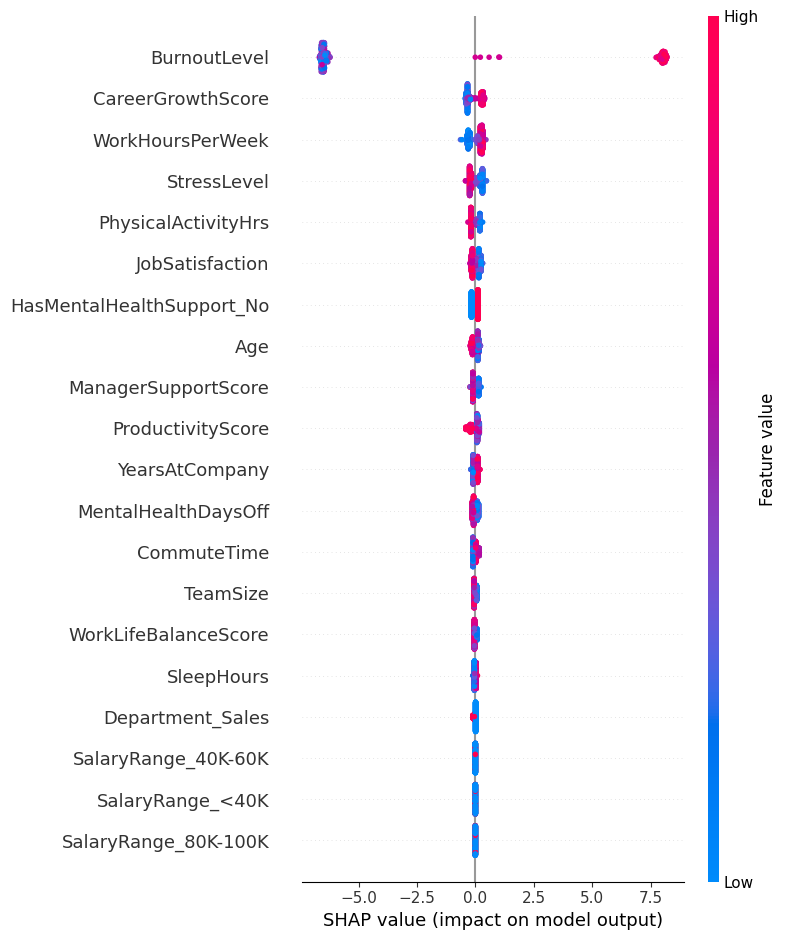


Generating SHAP Force Plot for a sample...


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix
import shap
import numpy as np
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer


# Assuming preprocessor, X_train, y_train, X_test, y_test are defined in previous cells
# Define numeric and categorical columns for preprocessor if not already defined
# This is a fallback in case the previous cells defining them are not run
try:
    numeric_cols
    categorical_cols
except NameError:
    print("numeric_cols or categorical_cols not found. Attempting to infer from X_train.")
    # Assuming X_train is a pandas DataFrame
    numeric_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = [col for col in X_train.columns if col not in numeric_cols]

# Re-define preprocessor if not already defined or if column inference was needed
try:
    preprocessor
except NameError:
    print("preprocessor not found. Defining it now.")
    numeric_pre = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])
    categorical_pre = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ])
    preprocessor = ColumnTransformer([
        ("num", numeric_pre, numeric_cols),
        ("cat", categorical_pre, categorical_cols)
    ], remainder="drop")


# Fit best model using standard Pipeline
best_model = Pipeline([
    ("pre", preprocessor),
    ("clf", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)) # Added random_state for reproducibility
])
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

# ------------------ 1. Confusion Matrix ------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No Burnout","Burnout"],
            yticklabels=["No Burnout","Burnout"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ------------------ 2. ROC Curve ------------------
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color="blue", label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0,1], [0,1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# ------------------ 3. Precision-Recall Curve ------------------
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(recall, precision, color="green", label="PR Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

# ------------------ 4. Feature Importance ------------------
# Access the classifier step within the pipeline
model_final = best_model.named_steps['clf']
plt.figure(figsize=(8,6))
# Ensure feature names are available for plotting
try:
    feature_names = numeric_cols + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))
except AttributeError: # Fallback for older sklearn versions
     feature_names = numeric_cols + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_cols))

xgb.plot_importance(model_final, importance_type="gain", max_num_features=15)
plt.title("Top Feature Importances (Gain)")
plt.show()

# ------------------ 5. SHAP Explainability ------------------
# Use the preprocessor and the fitted model
X_test_processed = preprocessor.transform(X_test)

# Ensure feature names for SHAP
try:
    feature_names_out = numeric_cols + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols))
except AttributeError: # Fallback for older sklearn versions
     feature_names_out = numeric_cols + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_cols))


explainer = shap.TreeExplainer(model_final)
shap_values = explainer.shap_values(X_test_processed)

# Summary Plot
print("\nGenerating SHAP Summary Plot...")
shap.summary_plot(shap_values, X_test_processed, feature_names=feature_names_out)

# Force Plot for one prediction (example)
print("\nGenerating SHAP Force Plot for a sample...")
shap.initjs()
i = 0 # Index of the sample to explain
display(shap.force_plot(explainer.expected_value, shap_values[i,:], feature_names=feature_names_out))

In [ ]:
# best_pipeline_with_visuals.py
"""
Stacked ensemble + calibration + SHAP + Publication-grade plots
for BurnoutRisk prediction on
/mnt/data/mental_health_workplace_survey.csv

Outputs saved in ./outputs/
"""

import os, json, time, warnings
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd
from collections import OrderedDict
RND = 42
np.random.seed(RND)

# ML imports
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, roc_auc_score,
    average_precision_score, classification_report, confusion_matrix,
    roc_curve, precision_recall_curve, brier_score_loss
)
from joblib import dump, load

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.1)

# Optional boosters & explainability
try:
    import xgboost as xgb
except Exception:
    xgb = None
try:
    import lightgbm as lgb
except Exception:
    lgb = None
try:
    from catboost import CatBoostClassifier
except Exception:
    CatBoostClassifier = None
try:
    import shap
except Exception:
    shap = None

# Optional: imblearn SMOTE
try:
    from imblearn.over_sampling import SMOTE
except Exception:
    SMOTE = None

# ------------------- Config -------------------
DATA_PATH = "/content/mental_health_workplace_survey.csv"
TARGET = "BurnoutRisk"   # 0/1
OUT_DIR = "./outputs"
os.makedirs(OUT_DIR, exist_ok=True)
PLOTS_DIR = os.path.join(OUT_DIR, "plots")
os.makedirs(PLOTS_DIR, exist_ok=True)

TEST_SIZE = 0.2
N_JOBS = -1
# RandomizedSearch iterations (small by default; increase for better tuning)
N_ITER_SEARCH = 25
CV_INNER = 3
CV_OUTER = 5

# ------------------- Utility functions -------------------
def save_json(obj, path):
    with open(path, "w") as f:
        json.dump(obj, f, indent=2)

def plot_and_save(fig, filename, dpi=200):
    path = os.path.join(PLOTS_DIR, filename)
    fig.savefig(path, bbox_inches="tight", dpi=dpi)
    plt.close(fig)
    print("Saved plot:", path)

# ------------------- Load data -------------------
df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", df.shape)
if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not in dataset")

# drop obvious ID if exists
if "EmployeeID" in df.columns:
    df = df.drop(columns=["EmployeeID"])

# Quick data check
print(df.head(3).T)

# ------------------- Preprocessing spec -------------------
# Auto-detect numeric vs categorical
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if TARGET in numeric_cols:
    numeric_cols.remove(TARGET)
categorical_cols = [c for c in df.columns if c not in numeric_cols + [TARGET]]

print("Numeric features:", numeric_cols)
print("Categorical features:", categorical_cols)

# Build transformers
numeric_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_pipe = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))])

preprocessor = ColumnTransformer([
    ("num", numeric_pipe, numeric_cols),
    ("cat", categorical_pipe, categorical_cols)
], remainder="drop")

# ------------------- Train/test split -------------------
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=TEST_SIZE, random_state=RND)
print("Train/test:", X_train.shape, X_test.shape, "Pos ratio (train):", y_train.mean())

# Fit preprocessor on training data (so transform shape is determined)
preprocessor.fit(X_train)
X_train_t = preprocessor.transform(X_train)
X_test_t = preprocessor.transform(X_test)

# Create transformed feature names (for plots & SHAP)
num_feat_names = numeric_cols
cat_feat_names = []
try:
    cat_feat_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_cols).tolist()
except Exception:
    # fallback for older sklearn
    try:
        cat_feat_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_cols).tolist()
    except Exception:
        cat_feat_names = categorical_cols
feature_names = num_feat_names + cat_feat_names
print("Final feature count:", len(feature_names))

# Optionally apply SMOTE on train set (only if highly imbalanced)
do_smote = False
if SMOTE is not None:
    counts = np.bincount(y_train)
    imbalance_ratio = counts.max() / (counts.min() + 1e-9)
    if imbalance_ratio > 1.2:
        do_smote = True
        print("Applying SMOTE, imbalance ratio:", imbalance_ratio)
if do_smote:
    sm = SMOTE(random_state=RND)
    X_train_t_balanced, y_train_balanced = sm.fit_resample(X_train_t, y_train)
else:
    X_train_t_balanced, y_train_balanced = X_train_t, y_train

# ------------------- Build base learners (with sensible defaults) -------------------
base_learners = OrderedDict()
# RandomForest (baseline)
rf = RandomForestClassifier(n_estimators=300, random_state=RND, n_jobs=N_JOBS)
base_learners['rf'] = rf

# XGBoost
if xgb is not None:
    xgb_clf = xgb.XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=6, random_state=RND, use_label_encoder=False, eval_metric="logloss", n_jobs=N_JOBS)
    base_learners['xgb'] = xgb_clf
else:
    print("xgboost not installed; skipping.")

# LightGBM
if lgb is not None:
    lgb_clf = lgb.LGBMClassifier(n_estimators=800, learning_rate=0.05, num_leaves=63, random_state=RND, n_jobs=N_JOBS)
    base_learners['lgb'] = lgb_clf
else:
    print("lightgbm not installed; skipping.")

# CatBoost
if CatBoostClassifier is not None:
    # CatBoost handles categorical natively, but we already OHEd; still include as model on transformed features
    cat_clf = CatBoostClassifier(iterations=800, learning_rate=0.05, depth=6, verbose=0, random_seed=RND)
    base_learners['catboost'] = cat_clf
else:
    print("catboost not installed; skipping.")

print("Base learners:", list(base_learners.keys()))
if len(base_learners) < 2:
    print("Warning: fewer than 2 base learners found; stacking advantage limited.")

# ------------------- Hyperparameter tuning (optional, limited runtime) -------------------
# For a quick run we skip heavy tuning — but provide a small random search for XGBoost/LightGBM if available.
tuned_learners = {}
for name, model in list(base_learners.items()):
    tuned_learners[name] = model  # default by default

# If you want heavy tuning set RUN_TUNING=True and adjust N_ITER_SEARCH
RUN_TUNING = False
if RUN_TUNING:
    for name, model in list(base_learners.items()):
        try:
            print("Tuning", name)
            if name == 'xgb' and xgb is not None:
                param_dist = {
                    "n_estimators": [200, 400, 800],
                    "max_depth": [3,5,7],
                    "learning_rate": [0.01, 0.05, 0.1],
                    "subsample":[0.6,0.8,1.0],
                }
            elif name == 'lgb' and lgb is not None:
                param_dist = {
                    "n_estimators":[200,400,800],
                    "num_leaves":[31,63,127],
                    "learning_rate":[0.01,0.05,0.1]
                }
            else:
                param_dist = {"n_estimators":[200,300,500]}
            search = RandomizedSearchCV(model, param_dist, n_iter=min(N_ITER_SEARCH,10), scoring='f1', cv=CV_INNER, n_jobs=N_JOBS, random_state=RND, verbose=1)
            search.fit(X_train_t_balanced, y_train_balanced)
            print(f"Best params for {name}:", search.best_params_)
            tuned_learners[name] = search.best_estimator_
            dump(search, os.path.join(OUT_DIR, f"{name}_search.joblib"))
        except Exception as e:
            print("Tuning failed for", name, e)
            tuned_learners[name] = model

# Use tuned learners (or defaults)
estimators_for_stack = [(k, tuned_learners[k]) for k in tuned_learners.keys()]

# ------------------- Build stacking pipeline -------------------
meta_learner = LogisticRegression(max_iter=2000, class_weight="balanced", random_state=RND)
stack = StackingClassifier(estimators=estimators_for_stack, final_estimator=meta_learner, cv=5, n_jobs=N_JOBS, passthrough=False)
# Fit stack on preprocessed features (already transformed)
print("Fitting stacking classifier on preprocessed features... (may take some minutes)")
t0 = time.time()
stack.fit(X_train_t_balanced, y_train_balanced)
print("Stack trained in {:.1f}s".format(time.time()-t0))
dump(stack, os.path.join(OUT_DIR, "stacking_model.joblib"))

# Calibrate probabilities (Platt scaling)
print("Calibrating stacked classifier probabilities (CalibratedClassifierCV with cv=3)")
calib = CalibratedClassifierCV(estimator=stack, method='sigmoid', cv=3)
calib.fit(X_train_t_balanced, y_train_balanced)
dump(calib, os.path.join(OUT_DIR, "calibrated_stacking.joblib"))

# ------------------- Evaluate on test set -------------------
y_pred = calib.predict(X_test_t)
try:
    y_proba = calib.predict_proba(X_test_t)[:,1]
except Exception:
    y_proba = calib.decision_function(X_test_t)
    y_proba = (y_proba - y_proba.min())/(y_proba.max() - y_proba.min() + 1e-9)

acc = accuracy_score(y_test, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary', zero_division=0)
roc = roc_auc_score(y_test, y_proba)
pr = average_precision_score(y_test, y_proba)
brier = brier_score_loss(y_test, y_proba)

metrics = {"accuracy":acc, "precision":prec, "recall":rec, "f1":f1, "roc_auc":roc, "pr_auc":pr, "brier":brier}
print("Test metrics:", metrics)
save_json(metrics, os.path.join(OUT_DIR, "final_metrics.json"))

# Save classification report and confusion matrix
report_txt = classification_report(y_test, y_pred, zero_division=0)
with open(os.path.join(OUT_DIR, "final_classification_report.txt"), "w") as f:
    f.write(report_txt)
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, index=["Actual_0","Actual_1"], columns=["Pred_0","Pred_1"]).to_csv(os.path.join(OUT_DIR, "final_confusion_matrix.csv"))

# ------------------- Plots for paper -------------------

# 1) Confusion matrix heatmap
fig = plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No","Yes"], yticklabels=["No","Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Stacked & Calibrated)")
plot_and_save(fig, "confusion_matrix.png")

# 2) ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
fig = plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"Stacked (AUC={roc:.3f})", lw=2)
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plot_and_save(fig, "roc_curve.png")

# 3) Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
fig = plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"Stacked (AP={pr:.3f})", lw=2)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plot_and_save(fig, "pr_curve.png")

# 4) Calibration plot
prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=10)
fig = plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label='Calibrated', lw=2)
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("Mean predicted probability"); plt.ylabel("Fraction of positives")
plt.title("Calibration Plot")
plt.legend()
plot_and_save(fig, "calibration_plot.png")

# 5) Feature importance: use best tree among base learners, else surrogate RF feature importance
# Choose a preferred explainable tree: xgb (if available) else lgb else rf
preferred_tree = None
if 'xgb' in tuned_learners and tuned_learners['xgb'] is not None:
    preferred_tree = tuned_learners['xgb']
elif 'lgb' in tuned_learners and tuned_learners['lgb'] is not None:
    preferred_tree = tuned_learners['lgb']
else:
    preferred_tree = tuned_learners.get('rf', None)

if preferred_tree is not None:
    try:
        # train preferred_tree on full training data (selected features)
        # fit preprocessor to get transformed data
        X_train_processed_for_importance = preprocessor.transform(X_train)
        preferred_tree.fit(X_train_processed_for_importance, y_train)
        # obtain importances (methods differ)
        if hasattr(preferred_tree, "feature_importances_"):
            imps = preferred_tree.feature_importances_
            imp_df = pd.DataFrame({"feature": feature_names, "importance": imps}).sort_values("importance", ascending=False).head(30)
            fig = plt.figure(figsize=(8,6))
            sns.barplot(data=imp_df, x="importance", y="feature")
            plt.title("Top feature importances (preferred tree)")
            plot_and_save(fig, "feature_importance_bar.png")
            imp_df.to_csv(os.path.join(OUT_DIR, "feature_importances.csv"), index=False)
    except Exception as e:
        print("Feature importance failed:", e)

# 6) SHAP explainability (global + dependence plots + local)
if shap is not None and preferred_tree is not None:
    try:
        print("Computing SHAP values (may take some minutes)...")
        # For tree models prefer TreeExplainer
        # X_test_t is already preprocessed and potentially SMOTEd, use preprocessed X_test for SHAP
        X_test_processed_for_shap = preprocessor.transform(X_test)

        if 'xgb' in tuned_learners and isinstance(preferred_tree, xgb.XGBClassifier):
            explainer = shap.TreeExplainer(preferred_tree)
            shap_values = explainer.shap_values(X_test_processed_for_shap)
        elif 'lgb' in tuned_learners and isinstance(preferred_tree, lgb.LGBMClassifier):
            explainer = shap.TreeExplainer(preferred_tree)
            shap_values = explainer.shap_values(X_test_processed_for_shap)
        else:
            explainer = shap.TreeExplainer(preferred_tree)
            shap_values = explainer.shap_values(X_test_processed_for_shap)
        # summary plot (global)
        # convert X_test_processed_for_shap to dataframe with feature names for clarity
        X_test_df = pd.DataFrame(X_test_processed_for_shap, columns=feature_names)
        fig = shap.summary_plot(shap_values, X_test_df, show=False)
        # shap.summary_plot returns matplot lib objects - save current figure
        plt.gcf().set_size_inches(8,6)
        plot_and_save(plt.gcf(), "shap_summary.png")
        # Dependence plot for top features (take first 3)
        mean_abs = np.mean(np.abs(shap_values), axis=0)
        top_idx = np.argsort(mean_abs)[-3:][::-1]
        for i, idx in enumerate(top_idx):
            feat = feature_names[idx]
            fig = shap.dependence_plot(feat, shap_values, X_test_df, display_features=X_test_df, show=False)
            plt.gcf().set_size_inches(8,6)
            plot_and_save(plt.gcf(), f"shap_dependence_{i+1}_{feat}.png")
        # Local force plot for a representative high-risk sample (largest predicted prob)
        hi = np.argmax(y_proba)
        # Force plot requires JS display in notebook; we'll save a static force figure via waterfall_plot
        try:
            fp = shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[hi,:], feature_names=feature_names, show=False)
            plt.gcf().set_size_inches(8,6)
            plot_and_save(plt.gcf(), f"shap_waterfall_sample_{hi}.png")
        except Exception:
            print("Force/waterfall plot failed; skipping local image.")
        # Save shap values dataframe (sample)
        sv_df = pd.DataFrame(shap_values, columns=feature_names)
        sv_df.to_csv(os.path.join(OUT_DIR, "shap_values_sample.csv"), index=False)
    except Exception as e:
        print("SHAP computation failed:", e)
else:
    print("SHAP or preferred tree not available; skipping SHAP visuals. To enable, pip install shap and xgboost/lightgbm")

# 7) t-SNE visualization colored by predicted probability (optional)
try:
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=RND)
    X_emb = tsne.fit_transform(X_test_t)
    fig = plt.figure(figsize=(7,5))
    sc = plt.scatter(X_emb[:,0], X_emb[:,1], c=y_proba, cmap='viridis', s=25)
    plt.colorbar(sc, label='Predicted burnout probability')
    plt.title("t-SNE of test samples colored by predicted burnout probability")
    plot_and_save(fig, "tsne_predprob.png")
except Exception as e:
    print("t-SNE failed or too slow:", e)

# ------------------- Save models & artifacts -------------------
dump(preprocessor, os.path.join(OUT_DIR, "preprocessor.joblib"))
dump(stack, os.path.join(OUT_DIR, "stack_raw.joblib"))
dump(calib, os.path.join(OUT_DIR, "stack_calibrated.joblib"))
pd.DataFrame({"y_test": y_test, "y_pred": y_pred, "y_proba": y_proba}).to_csv(os.path.join(OUT_DIR, "test_predictions_with_proba.csv"), index=False)

print("All outputs saved to", OUT_DIR)
print("Plot files in", PLOTS_DIR)

Loaded dataset: (3000, 25)
                                      0                  1           2
Age                                  50                 36          29
Gender                             Male               Male  Non-binary
Country                              UK            Germany       India
JobRole                 Sales Associate  Software Engineer    IT Admin
Department                           HR                 IT          IT
YearsAtCompany                       14                  1          13
WorkHoursPerWeek                     47                 59          59
RemoteWork                           No             Hybrid      Hybrid
BurnoutLevel                       3.37               7.39         7.1
JobSatisfaction                    5.06                2.0        7.17
StressLevel                        9.47               5.65         5.7
ProductivityScore                  4.16               3.74         8.8
SleepHours                          7.0           